In [1]:
import sys
sys.path.append("../")

import torch as th
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from src.datamodule import BarcodeDM
from src.config import Config
from src.segment_model import BarcodeModel


In [2]:
class SegmModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name, 
            in_channels=in_channels, 
            classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", th.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", th.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0, f"{h=} {w=}"

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = th.cat([x["tp"] for x in outputs])
        fp = th.cat([x["fp"] for x in outputs])
        fn = th.cat([x["fn"] for x in outputs])
        tn = th.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return th.optim.Adam(self.parameters(), lr=0.0001)
    

In [3]:
model = SegmModel("FPN", "resnet34", in_channels=3, out_classes=1)

In [4]:
cfg = Config.from_yaml("../config/baseline_segm.yml")
data = BarcodeDM(cfg.data_config, task="segmentation", dry_run=False)
data.prepare_data()
data.setup()


In [5]:
th.set_num_threads(4)
trainer = pl.Trainer(
    # gpus=1, 
    # max_epochs=5,
    overfit_batches=10
)

trainer.fit(model, datamodule=data)

/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:468: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(
/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.mean, model.std

In [6]:
for b in data.train_dataloader():
    break

In [ ]:
model.training_step(b,0)

In [7]:
b["image"]

tensor([[[[157, 157, 154,  ..., 118, 118, 116],
          [154, 158, 160,  ..., 119, 118, 116],
          [156, 160, 161,  ..., 119, 119, 116],
          ...,
          [ 79,  78,  80,  ...,  63,  62,  62],
          [ 77,  74,  75,  ...,  65,  64,  65],
          [ 74,  70,  72,  ...,  61,  62,  63]],

         [[132, 132, 129,  ...,  88,  88,  86],
          [129, 133, 135,  ...,  89,  88,  86],
          [131, 135, 136,  ...,  89,  89,  86],
          ...,
          [ 42,  41,  43,  ...,  38,  37,  38],
          [ 40,  37,  38,  ...,  39,  39,  38],
          [ 38,  33,  34,  ...,  36,  35,  34]],

         [[102, 102,  99,  ...,  50,  52,  52],
          [ 99, 103, 105,  ...,  51,  52,  52],
          [101, 105, 106,  ...,  51,  53,  52],
          ...,
          [ 34,  33,  35,  ...,  31,  30,  30],
          [ 32,  29,  30,  ...,  33,  32,  32],
          [ 30,  25,  26,  ...,  29,  28,  28]]],


        [[[142, 143, 148,  ..., 164, 172, 170],
          [139, 143, 145,  ..., 170

In [9]:
pred = model(b["image"])
pred.shape

torch.Size([4, 1, 640, 512])

In [11]:
import matplotlib.pyplot as plt

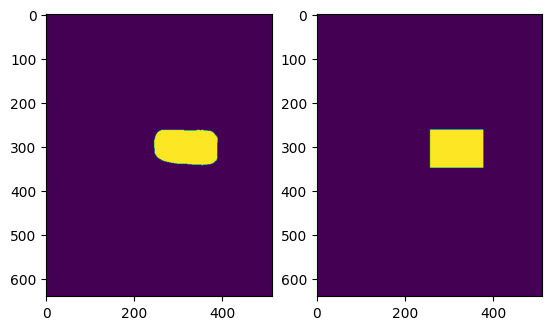

In [12]:

img_pred = pred[0].squeeze()
img_mask = b["mask"][0].squeeze()

plt.subplot(1,2,1)
plt.imshow((th.sigmoid(img_pred)>0.5).to(int)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(img_mask.to(int))  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [ ]:
img_mask

In [ ]:
record = data.train_dataset[0]

img = record["image"]

img.shape

In [ ]:
img.min()

In [ ]:
img.max()

In [ ]:
record["mask"].shape

In [ ]:
loader = data.train_dataloader()

In [ ]:
loader.batch_size

In [ ]:
data.train_dataset[0]

In [ ]:
for b in data.train_dataloader():
    break

In [ ]:
b["image"].shape

In [ ]:
import torchvision as thv

In [ ]:
img

In [ ]:
thv.transforms.functional.resize()

In [ ]:
32*40

In [ ]:
32*33

In [ ]:
import numpy as np

In [ ]:

arr = np.array([[1,2],[3,4]])

In [ ]:
arr.size